# **Aplikasi Deteksi Suara Buka Tutup**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import os
import pandas as pd
from IPython.display import Audio, display

In [6]:
data = "/content/gdrive/MyDrive/voice-v2/Deteksi-suara-buka-tutup-dan-pengenalan-suara/data_preprocessed"

input_base = data
output_base = "data_preprocessed"

os.makedirs(output_base, exist_ok=True)

In [7]:
def preprocess_audio(input_path, output_path, sr=16000):
    # Load audio
    y, _ = librosa.load(input_path, sr=sr)

    # Trim silence
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)

    # Normalisasi amplitudo
    y_norm = y_trimmed / np.max(np.abs(y_trimmed))

    # Simpan
    sf.write(output_path, y_norm, sr)

In [13]:
rows = []

for name in ['Ardhi', 'Ilham']:
    temp = os.path.join(data, name)
    print(temp)
    for file_name in ["buka", "tutup"]:
        input_folder = os.path.join(temp, file_name)
        list_audio = os.listdir(input_folder)

        output_folder = os.path.join(output_base, name, file_name)
        os.makedirs(output_folder, exist_ok=True)

        for name_audio in list_audio:
            if name_audio.endswith(".wav"):
                from_path = os.path.join(input_folder, name_audio)
                clear_path = os.path.join(output_folder, name_audio)

                try:
                    preprocess_audio(from_path, clear_path)
                    rows.append({
                        "split": name_audio,
                        "speaker": name,
                        "label_command": file_name,
                        "file_path": clear_path
                    })
                except Exception as e:
                    print(f"Error {name_audio}: {e}")

metadata= pd.DataFrame(rows)
metadata.to_csv(os.path.join(output_base, "/content/gdrive/MyDrive/voice-v2/Deteksi-suara-buka-tutup-dan-pengenalan-suara/data_preprocessed/metadata.csv"), index=False)
print("done!")

/content/gdrive/MyDrive/voice-v2/Deteksi-suara-buka-tutup-dan-pengenalan-suara/data_preprocessed/Ardhi
/content/gdrive/MyDrive/voice-v2/Deteksi-suara-buka-tutup-dan-pengenalan-suara/data_preprocessed/Ilham
done!


Durasi sebelum preprocessing : 1.15 detik
Durasi sesudah preprocessing : 1.22 detik



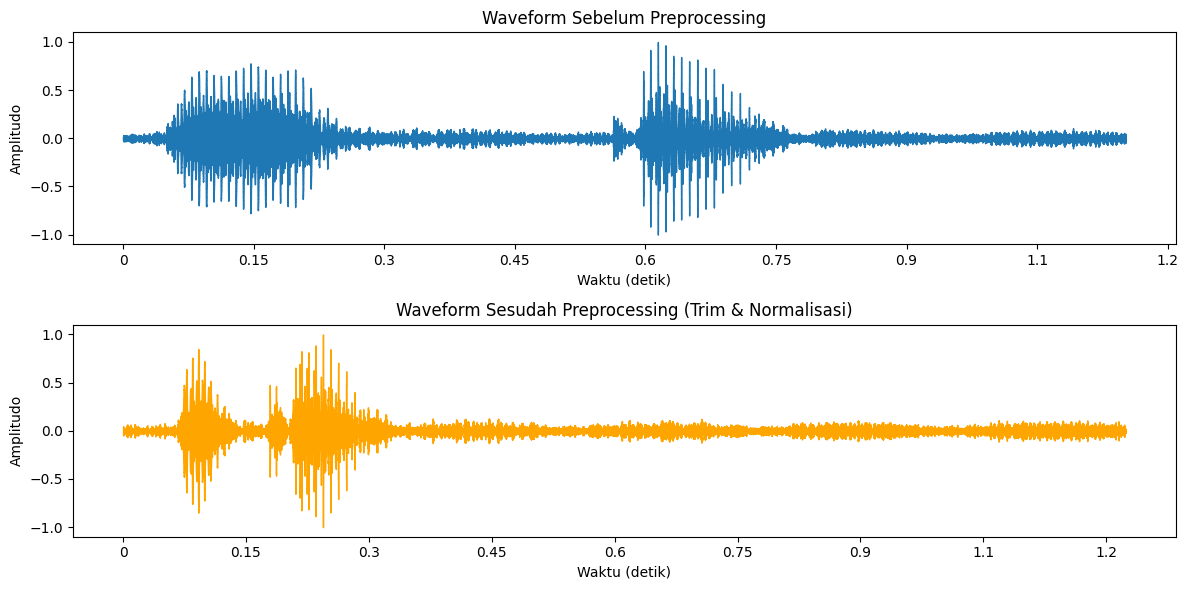

 Sebelum preprocessing:


 Sesudah preprocessing:


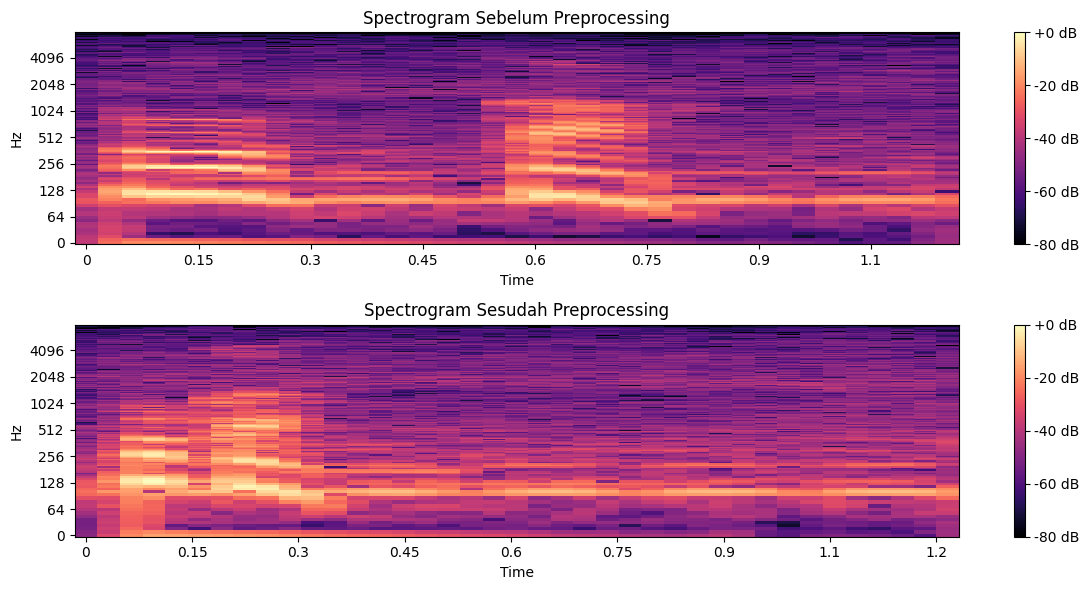

In [14]:
path = "/content/gdrive/MyDrive/voice-v2/Deteksi-suara-buka-tutup-dan-pengenalan-suara/data_preprocessed/Ilham/buka"
preprocessed_file = os.path.join(output_base, path, os.listdir(os.path.join(output_base, "Ilham", "buka"))[0])

original_file = os.path.join(data, path, os.listdir(os.path.join(data, "Ilham", "buka"))[0])

y_orig, sr_orig = librosa.load(original_file, sr=16000)
y_proc, sr_proc = librosa.load(preprocessed_file, sr=16000)

durasi_asli = librosa.get_duration(y=y_orig, sr=sr_orig)
durasi_baru = librosa.get_duration(y=y_proc, sr=sr_proc)

print(f"Durasi sebelum preprocessing : {durasi_asli:.2f} detik")
print(f"Durasi sesudah preprocessing : {durasi_baru:.2f} detik\n")

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y_orig, sr=sr_orig)
plt.title("Waveform Sebelum Preprocessing")
plt.xlabel("Waktu (detik)")
plt.ylabel("Amplitudo")

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_proc, sr=sr_proc, color='orange')
plt.title("Waveform Sesudah Preprocessing (Trim & Normalisasi)")
plt.xlabel("Waktu (detik)")
plt.ylabel("Amplitudo")

plt.tight_layout()
plt.show()

print(" Sebelum preprocessing:")
display(Audio(data=y_orig, rate=sr_orig))

print(" Sesudah preprocessing:")
display(Audio(data=y_proc, rate=sr_proc))

S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(y_orig)), ref=np.max)
S_proc = librosa.amplitude_to_db(np.abs(librosa.stft(y_proc)), ref=np.max)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
librosa.display.specshow(S_orig, sr=sr_orig, x_axis='time', y_axis='log')
plt.colorbar(format="%+2.f dB")
plt.title("Spectrogram Sebelum Preprocessing")

plt.subplot(2, 1, 2)
librosa.display.specshow(S_proc, sr=sr_proc, x_axis='time', y_axis='log')
plt.colorbar(format="%+2.f dB")
plt.title("Spectrogram Sesudah Preprocessing")

plt.tight_layout()
plt.show()

In [16]:
from scipy.stats import skew, kurtosis

def agg_stats(x):
    return {
        'mean': np.mean(x),
        'std': np.std(x),
        'median': np.median(x),
        'skew': skew(x) if len(x)>2 else 0.0,
        'kurtosis': kurtosis(x) if len(x)>2 else 0.0
    }

def extract_features(file_path, speaker, label_command):
    y, sr = librosa.load(file_path, sr=16000)  # atur sr sesuai dataset
    features = {}
    # temporal
    z = librosa.feature.zero_crossing_rate(y)[0]
    rms = librosa.feature.rms(y=y)[0]
    features.update({f'zcr_{k}':v for k,v in agg_stats(z).items()})
    features.update({f'rms_{k}':v for k,v in agg_stats(rms).items()})
    features['duration'] = len(y)/sr
    # spectral
    sc = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    sb = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    roll = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)[0]
    flat = librosa.feature.spectral_flatness(y=y)[0]
    features.update({f'sc_{k}':v for k,v in agg_stats(sc).items()})
    features.update({f'sb_{k}':v for k,v in agg_stats(sb).items()})
    features.update({f'roll_{k}':v for k,v in agg_stats(roll).items()})
    features.update({f'contrast_{k}':v for k,v in agg_stats(spec_contrast).items()})
    features.update({f'flat_{k}':v for k,v in agg_stats(flat).items()})
    # mfcc (ambil beberapa koefisien, dan agregat per koef)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(mfcc.shape[0]):
        stats = agg_stats(mfcc[i])
        features.update({f'mfcc{i+1}_{k}':v for k,v in stats.items()})
    # f0 (pitch) -- gunakan yin jika cocok
    try:
        f0 = librosa.yin(y, fmin=50, fmax=500, sr=sr)
        features.update({f'f0_{k}':v for k,v in agg_stats(f0).items()})
    except Exception:
        features.update({'f0_mean':0.0, 'f0_std':0.0, 'f0_median':0.0, 'f0_skew':0.0, 'f0_kurtosis':0.0})

    features['speaker'] = speaker
    features['label_command'] = label_command
    return features

# loop folder
data = []
audio = pd.read_csv(os.path.join(output_base, "/content/gdrive/MyDrive/voice-v2/Deteksi-suara-buka-tutup-dan-pengenalan-suara/data_preprocessed/metadata.csv"))
for _, col in audio.iterrows():
    path_audio = col['file_path']
    data.append(extract_features(path_audio, col['speaker'], col['label_command']))

df = pd.DataFrame(data)
df.to_csv('/content/gdrive/MyDrive/voice-v2/Deteksi-suara-buka-tutup-dan-pengenalan-suara/model/features_all.csv', index=False)
print("Done, features shape:", df.shape)

Done, features shape: (209, 108)


In [17]:
df.isnull().sum()

,0
zcr_mean,0
zcr_std,0
zcr_median,0
zcr_skew,0
zcr_kurtosis,0
...,...
f0_median,0
f0_skew,0
f0_kurtosis,0
speaker,0


In [18]:
features_df = df.dropna()
features_df

,zcr_mean,zcr_std,zcr_median,zcr_skew,zcr_kurtosis,rms_mean,rms_std,rms_median,rms_skew,rms_kurtosis,...,mfcc13_median,mfcc13_skew,mfcc13_kurtosis,f0_mean,f0_std,f0_median,f0_skew,f0_kurtosis,speaker,label_command
0,0.046875,0.042456,0.031982,2.184896,3.707423,0.127303,0.104449,0.114612,0.217827,-1.511346,...,-1.512823,-1.048452,-0.049480,125.617891,65.497405,132.908397,2.128887,6.478600,Ardhi,buka
1,0.059540,0.027830,0.071777,-0.259216,-1.163982,0.161281,0.077530,0.166477,0.007372,-1.188347,...,-23.511860,1.705018,2.488226,167.276945,67.126147,146.431788,2.205199,2.989568,Ardhi,buka
2,0.066406,0.036590,0.074219,0.266045,-1.007885,0.141485,0.071304,0.137067,0.241827,-0.968194,...,-12.747983,0.154047,-1.321411,117.814388,30.225376,125.229884,-1.027455,-0.480097,Ardhi,buka
3,0.043815,0.020270,0.039551,0.018781,-1.577349,0.162771,0.092556,0.131959,0.197846,-1.472616,...,-12.442647,0.475024,-1.052963,157.794811,87.931555,130.660824,3.439868,9.922201,Ardhi,buka
4,0.032648,0.021735,0.026367,1.373778,0.642078,0.176173,0.106659,0.177679,0.198617,-1.066603,...,-3.256263,0.540321,-0.622952,135.810748,58.851286,126.190916,3.860000,14.701242,Ardhi,buka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0.040248,0.011242,0.035645,1.246116,0.246287,0.181627,0.097920,0.211850,-0.026515,-1.233892,...,-11.748243,1.007843,0.760581,139.702441,16.242097,133.124262,1.488005,0.863880,Ilham,tutup
205,0.062514,0.032459,0.051270,1.312251,0.604245,0.136898,0.117919,0.050991,0.567471,-1.344733,...,-7.114607,-0.780126,0.411814,101.695403,24.958606,104.417850,-1.142083,0.139406,Ilham,tutup
206,0.057754,0.025761,0.043945,1.249299,0.308372,0.230350,0.138660,0.236922,0.001073,-1.205629,...,-7.008475,-0.932273,0.277168,115.520688,23.235419,121.999136,-1.207480,0.501959,Ilham,tutup
207,0.064616,0.020029,0.059326,0.661862,-0.755185,0.192935,0.117820,0.207875,-0.234685,-1.356403,...,-6.457622,-0.087650,0.063624,125.390980,32.305489,129.994969,-0.017309,2.449080,Ilham,tutup


In [19]:
features_df.isnull().sum()

,0
zcr_mean,0
zcr_std,0
zcr_median,0
zcr_skew,0
zcr_kurtosis,0
...,...
f0_median,0
f0_skew,0
f0_kurtosis,0
speaker,0


In [20]:
features_df.to_csv("/content/gdrive/MyDrive/voice-v2/Deteksi-suara-buka-tutup-dan-pengenalan-suara/data_suara.csv")

In [21]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

df = features_df
# buat label gabungan jika mau (speaker + command)
df['label_full'] = df['speaker'] + "_" + df['label_command']

# drop kolom non numeric
X = df.drop(columns=['speaker','label_command','label_full'])
# pastikan hanya numeric
X = X.select_dtypes(include=[np.number]).fillna(0)

# target (pilih target sesuai kebutuhan)
y = df['label_full']  # atau gunakan 'label_command' untuk hanya command

# scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Seleksi Fitur

In [22]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# model untuk mendeteksi buka/tutup
y_command = LabelEncoder().fit_transform(df['label_command'])
X = df.drop(columns=['label_full','speaker', 'label_command'])

mi_command = mutual_info_classif(X, y_command, random_state=42)
mi_scores_command = pd.Series(mi_command, index=X.columns).sort_values(ascending=False)

selected_features_command  = mi_scores_command[mi_scores_command > 0.3].index.tolist()
print(selected_features_command )

['mfcc8_mean', 'mfcc8_median', 'mfcc11_mean', 'mfcc3_median', 'sc_mean', 'mfcc4_mean']


In [23]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# model untuk mendeteksi buka/tutup
y_command = LabelEncoder().fit_transform(df['speaker'])
X = df.drop(columns=['label_full','speaker', 'label_command'])

mi_command = mutual_info_classif(X, y_command, random_state=42)
mi_scores_command = pd.Series(mi_command, index=X.columns).sort_values(ascending=False)

selected_features_speaker  = mi_scores_command[mi_scores_command > 0.3].index.tolist()
print(selected_features_speaker )

['mfcc3_mean', 'mfcc1_std', 'mfcc4_median', 'mfcc3_median', 'mfcc4_mean', 'contrast_mean', 'contrast_median', 'mfcc11_median', 'mfcc5_skew', 'mfcc11_mean', 'flat_median', 'f0_median', 'flat_mean', 'mfcc7_std', 'mfcc3_std']


## Modelling

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pickle

In [25]:
df = pd.read_csv('/content/gdrive/MyDrive/voice-v2/Deteksi-suara-buka-tutup-dan-pengenalan-suara/features_all.csv')

# --- Command Model ---
X_command = df[['mfcc8_mean', 'mfcc8_median', 'mfcc11_mean', 'sc_mean', 'mfcc3_median']]
le_command = LabelEncoder()
y_command = le_command.fit_transform(df['label_command'])

# --- Speaker Model ---
X_speaker = df[['mfcc3_mean', 'mfcc1_std', 'mfcc4_median', 'mfcc4_mean', 'mfcc3_median',
                'contrast_mean', 'contrast_median', 'mfcc11_median', 'mfcc5_skew',
                'mfcc7_std', 'flat_median', 'mfcc11_mean', 'f0_median', 'f0_std', 'mfcc3_std']]
le_speaker = LabelEncoder()
y_speaker = le_speaker.fit_transform(df['speaker'])

In [26]:
scaler_command = StandardScaler()
X_command_scaled = scaler_command.fit_transform(X_command)

scaler_speaker = StandardScaler()
X_speaker_scaled = scaler_speaker.fit_transform(X_speaker)

In [27]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_command_scaled, y_command, test_size=0.3, random_state=42
)
model_command = RandomForestClassifier(random_state=42)
model_command.fit(Xc_train, yc_train)
print("Command Accuracy:", accuracy_score(yc_test, model_command.predict(Xc_test)))

# Simpan model dan scaler
with open("model_command.pkl", "wb") as f:
    pickle.dump(model_command, f)

with open("scaler_command.pkl", "wb") as f:
    pickle.dump(scaler_command, f)

with open("le_command.pkl", "wb") as f:
    pickle.dump(le_command, f)

Command Accuracy: 0.9682539682539683


In [28]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    X_speaker_scaled, y_speaker, test_size=0.3, random_state=42
)
model_speaker = RandomForestClassifier(random_state=42)
model_speaker.fit(Xs_train, ys_train)
print("Speaker Accuracy:", accuracy_score(ys_test, model_speaker.predict(Xs_test)))

with open("model_speaker.pkl", "wb") as f:
    pickle.dump(model_speaker, f)

with open("scaler_speaker.pkl", "wb") as f:
    pickle.dump(scaler_speaker, f)

with open("le_speaker.pkl", "wb") as f:
    pickle.dump(le_speaker, f)

Speaker Accuracy: 1.0


In [34]:
!apt-get install -y portaudio19-dev
!pip install sounddevice

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 41 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 1s (348 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 125082 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.

In [35]:
from scipy.stats import skew, kurtosis
import sounddevice as sd
import soundfile as sf
from IPython.display import Audio, display
# load model

le_command = pickle.load(open("/content/gdrive/MyDrive/voice-v2/Deteksi-suara-buka-tutup-dan-pengenalan-suara/model/le_command.pkl", "rb"))
model_command = pickle.load(open("/content/gdrive/MyDrive/voice-v2/Deteksi-suara-buka-tutup-dan-pengenalan-suara/model/model_command.pkl", "rb"))
scaler_command = pickle.load(open("/content/gdrive/MyDrive/voice-v2/Deteksi-suara-buka-tutup-dan-pengenalan-suara/model/scaler_command.pkl", "rb"))

le_speaker = pickle.load(open("/content/gdrive/MyDrive/voice-v2/Deteksi-suara-buka-tutup-dan-pengenalan-suara/model/le_speaker.pkl", "rb"))
model_speaker = pickle.load(open("/content/gdrive/MyDrive/voice-v2/Deteksi-suara-buka-tutup-dan-pengenalan-suara/model/model_speaker.pkl", "rb"))
scaler_speaker = pickle.load(open("/content/gdrive/MyDrive/voice-v2/Deteksi-suara-buka-tutup-dan-pengenalan-suara/model/scaler_speaker.pkl", "rb"))

file_path = "/content/gdrive/MyDrive/voice-v2/Deteksi-suara-buka-tutup-dan-pengenalan-suara/data_preprocessed/Ilham/buka/5 Nov, 20.24​(3).wav"

# file_path = "data_preprocessed/test/test1.wav"
# # Rekam selama 3 detik
# duration = 2
# sr = 16000
# print("Mulai rekam...")
# recording = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
# sd.wait()
# print("Rekaman selesai!")

# sf.write(file_path, recording, sr)


def agg_stats(x):
    return {
        'mean': np.mean(x),
        'std': np.std(x),
        'median': np.median(x),
        'skew': skew(x) if len(x)>2 else 0.0,
        'kurtosis': kurtosis(x) if len(x)>2 else 0.0
    }

def extract_features(file_path):
    sr = 16000
    y, _ = librosa.load(file_path, sr=sr)
    display(Audio(data=y, rate=_))

    features = {}

    # temporal
    z = librosa.feature.zero_crossing_rate(y)[0]
    rms = librosa.feature.rms(y=y)[0]
    features.update({f'zcr_{k}':v for k,v in agg_stats(z).items()})
    features.update({f'rms_{k}':v for k,v in agg_stats(rms).items()})
    features['duration'] = len(y)/sr

    # spectral
    sc = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    sb = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    roll = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)[0]
    flat = librosa.feature.spectral_flatness(y=y)[0]
    features.update({f'sc_{k}':v for k,v in agg_stats(sc).items()})
    features.update({f'sb_{k}':v for k,v in agg_stats(sb).items()})
    features.update({f'roll_{k}':v for k,v in agg_stats(roll).items()})
    features.update({f'contrast_{k}':v for k,v in agg_stats(spec_contrast).items()})
    features.update({f'flat_{k}':v for k,v in agg_stats(flat).items()})

    # mfcc (ambil beberapa koefisien, dan agregat per koef)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(mfcc.shape[0]):
        stats = agg_stats(mfcc[i])
        features.update({f'mfcc{i+1}_{k}':v for k,v in stats.items()})
    # f0 (pitch) -- gunakan yin jika cocok
    try:
        f0 = librosa.yin(y, fmin=50, fmax=500, sr=sr)
        features.update({f'f0_{k}':v for k,v in agg_stats(f0).items()})
    except Exception:
        features.update({'f0_mean':0.0, 'f0_std':0.0, 'f0_median':0.0, 'f0_skew':0.0, 'f0_kurtosis':0.0})

    return features

# loop folder
data = []

data.append(extract_features(file_path))

df = pd.DataFrame(data)
# Fitur penting untuk masing-masing model
selected_features_command = ['mfcc8_mean', 'mfcc8_median', 'mfcc11_mean', 'sc_mean', 'mfcc3_median']

selected_features_speaker = ['mfcc3_mean', 'mfcc1_std', 'mfcc4_median', 'mfcc4_mean', 'mfcc3_median',
                             'contrast_mean', 'contrast_median', 'mfcc11_median', 'mfcc5_skew',
                             'mfcc7_std', 'flat_median', 'mfcc11_mean', 'f0_median', 'f0_std', 'mfcc3_std']

X_command = df[selected_features_command]
X_speaker = df[selected_features_speaker]

X_command_scaled = scaler_command.transform(X_command)
X_speaker_scaled = scaler_speaker.transform(X_speaker)

pred_command = model_command.predict(X_command_scaled)[0]
pred_speaker = model_speaker.predict(X_speaker_scaled)[0]

pred_command_prob = model_command.predict_proba(X_command_scaled)[0]
confidence_command = max(pred_command_prob) * 100

pred_speaker_prob = model_speaker.predict_proba(X_speaker_scaled)[0]
confidence_speaker = max(pred_speaker_prob) * 100

label_command = le_command.inverse_transform([pred_command])[0]
speaker_label = le_speaker.inverse_transform([pred_speaker])[0]


THRESHOLD = 70

print("\n🎧 HASIL PREDIKSI:")

if confidence_command >= THRESHOLD and confidence_speaker >= THRESHOLD:
    print(f"Dikenali sebagai : {speaker_label}")
    print(f"Identifikasi sebagai : {label_command}")

    print(f"Confidence command : {confidence_command:.2f}%")
    print(f"Confidence speaker : {confidence_speaker:.2f}%")

else:
    print("Suara tidak dikenali (bukan 2 orang yang terdaftar)")
    print(f"Confidence command hanya {confidence_command:.2f}% < {THRESHOLD}%")
    print(f"Confidence speaker hanya {confidence_speaker:.2f}% < {THRESHOLD}%")

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.2 when using version 1.6.1. This might lead to bre


🎧 HASIL PREDIKSI:
Dikenali sebagai : Ilham
Identifikasi sebagai : buka
Confidence command : 100.00%
Confidence speaker : 100.00%


## Link Deployment

Bisa diakses lewat link berikut : https://deteksi-suara-buka-tutup-dan-pengenalan-v2.streamlit.app/